In [102]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [103]:
from read_data import load_df
import numpy as np
from preprocessing import PrepareData

In [104]:
from jupyterthemes import jtplot
jtplot.style()

In [105]:
df = load_df()
import pickle
pickle.dump(df, open('tunning/lstm_df.pkl', 'wb'))

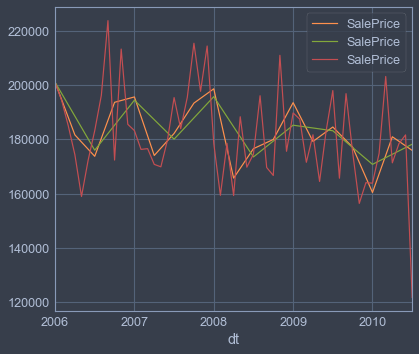

In [14]:
df = load_df()
values = df.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

sales_price = df[['SalePrice']]
df.SalePrice.resample('3M').mean().plot(color='y', legend=True)
df.SalePrice.resample('6M').mean().plot(color='g', legend=True)
df.SalePrice.resample('M').mean().plot(color='r', legend=True)
plt.show()

In [30]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
df_target = pd.DataFrame(scaled)

In [32]:
reframed = series_to_supervised(scaled, 6)
# split into train and test sets
values = reframed.values
n_train_time = int(reframed.shape[0]*0.9)
train = values[:n_train_time, :]
test = values[n_train_time:, :]

In [33]:
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

((1308, 1, 1616), (1308,), (146, 1, 1616), (146,))


In [ ]:
model = Sequential()
model.add(LSTM(800, input_shape=(train_x.shape[1], train_x.shape[2]), activation='relu', return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(800))
# model.add(Dense(600, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_x, train_y, epochs=80, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=True)

Train on 1308 samples, validate on 146 samples
Epoch 1/80
 - 8s - loss: 0.1547 - val_loss: 0.0114
Epoch 2/80
 - 3s - loss: 0.0112 - val_loss: 0.0097
Epoch 3/80
 - 3s - loss: 0.0071 - val_loss: 0.0068
Epoch 4/80
 - 3s - loss: 0.0058 - val_loss: 0.0052
Epoch 5/80
 - 4s - loss: 0.0042 - val_loss: 0.0045
Epoch 6/80
 - 3s - loss: 0.0035 - val_loss: 0.0038
Epoch 7/80
 - 3s - loss: 0.0031 - val_loss: 0.0038
Epoch 8/80
 - 3s - loss: 0.0024 - val_loss: 0.0033
Epoch 9/80
 - 3s - loss: 0.0021 - val_loss: 0.0032
Epoch 10/80
 - 3s - loss: 0.0019 - val_loss: 0.0029
Epoch 11/80
 - 3s - loss: 0.0018 - val_loss: 0.0028
Epoch 12/80
 - 3s - loss: 0.0017 - val_loss: 0.0027
Epoch 13/80
 - 3s - loss: 0.0016 - val_loss: 0.0028
Epoch 14/80
 - 4s - loss: 0.0017 - val_loss: 0.0035
Epoch 15/80
 - 3s - loss: 0.0015 - val_loss: 0.0026
Epoch 16/80
 - 3s - loss: 0.0013 - val_loss: 0.0026
Epoch 17/80
 - 3s - loss: 0.0013 - val_loss: 0.0026
Epoch 18/80
 - 3s - loss: 0.0010 - val_loss: 0.0029
Epoch 19/80
 - 3s - loss: 

In [109]:
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 1, 800)            7734400   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 800)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 800)               5123200   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 801       
Total params: 12,858,401
Trainable params: 12,858,401
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
# make a prediction
pred_train = model.predict(train_x)
print 'RMSE (Training Data):', mean_squared_error(train_y , pred_train)

RMSE (Training Data): 0.0001657477013757029


RMSE is: 0.002372872930313124


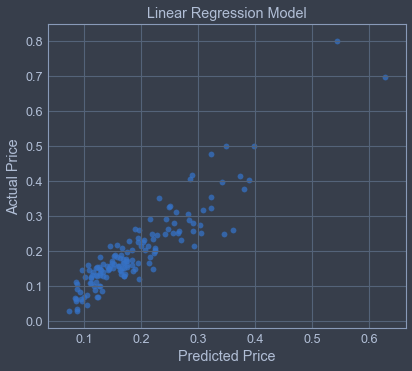

In [100]:
pred_test = model.predict(test_x)
print 'RMSE (Testin Data):', mean_squared_error(test_y , pred_test)
plt.scatter(pred_test, test_y, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

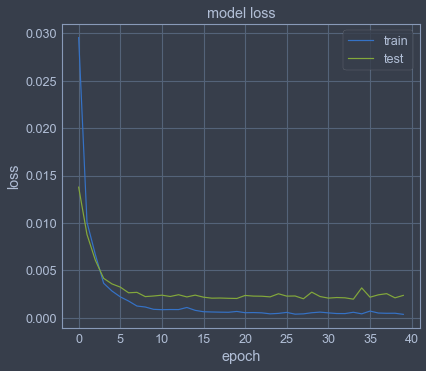

In [101]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

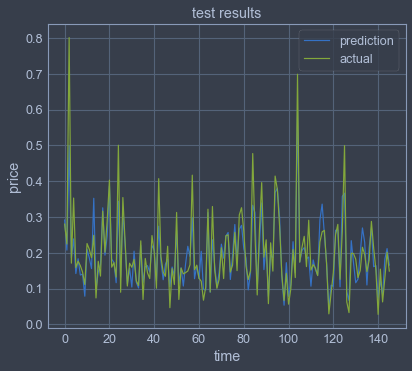

In [79]:
plt.plot(predictions)
plt.plot(test_y)
plt.title('test results')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['prediction', 'actual'], loc='upper right')
plt.show()